# CS 770 ML Assignment 3:  
# Fashion MNIST Classification
* Submitted By:
    * Sri Teja Muthangi
    * W862g253

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch

# reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
# printing versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("tensorflow:", tf.__version__)
print("torch:", torch.__version__)

numpy: 2.2.6
pandas: 2.3.3
matplotlib: 3.10.7
seaborn: 0.13.2
scikit-learn: 1.7.2
tensorflow: 2.20.0
torch: 2.9.1+cpu


## Question 1: Neural Network with Hyperparameter Tuning

In [2]:
# Neural Network with Hyperparameter Tuning

# loading IDX data
def load_idx_images(path):
    with open(path, "rb") as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    count = int.from_bytes(data[4:8], "big")
    rows = int.from_bytes(data[8:12], "big")
    cols = int.from_bytes(data[12:16], "big")
    return data[16:].reshape(count, rows, cols)


def load_idx_labels(path):
    with open(path, "rb") as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data[8:]

folder = r"C:\Users\sriteja\Desktop\Sem-I\ML\Codes\MLAssignment3\fashionmnist\versions\4"

train_images = load_idx_images(os.path.join(folder, "train-images-idx3-ubyte"))
train_labels = load_idx_labels(os.path.join(folder, "train-labels-idx1-ubyte"))

test_images = load_idx_images(os.path.join(folder, "t10k-images-idx3-ubyte"))
test_labels = load_idx_labels(os.path.join(folder, "t10k-labels-idx1-ubyte"))


# preprocessing
train_images = train_images.astype("float32") / 255
test_images  = test_images.astype("float32") / 255

train_images = train_images.reshape(-1, 28*28)
test_images  = test_images.reshape(-1, 28*28)

train_labels = to_categorical(train_labels, 10)
test_labels  = to_categorical(test_labels, 10)

# 80/20 split with fixed seed
x_train2, x_val, y_train2, y_val = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    shuffle=True,
    random_state=seed
)

x_test = test_images
y_test = test_labels


In [3]:
# model builder
def build_model(hidden_units=[128, 64], activation="relu", lr=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(784,)))
    for u in hidden_units:
        model.add(layers.Dense(u, activation=activation))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# experimental configs -> one at a time tuning
configs = [
    {"hidden":[128,64], "act":"relu", "lr":0.001, "bs":64},     
    {"hidden":[256,128], "act":"relu", "lr":0.001, "bs":64},    
    {"hidden":[512,256,128], "act":"relu", "lr":0.001, "bs":64},
    {"hidden":[128,64], "act":"tanh", "lr":0.001, "bs":64},
    {"hidden":[128,64], "act":"relu", "lr":0.01, "bs":64},
]


# running experiments
import time
results = []
histories = []

for cfg in configs:
    print("Running:", cfg)
    model = build_model(cfg["hidden"], cfg["act"], cfg["lr"])

    start = time.time()
    history = model.fit(
        x_train2, y_train2,
        validation_data=(x_val, y_val),
        epochs=30,
        batch_size=cfg["bs"],
        verbose=0
    )
    end = time.time()

    loss_test, acc_test = model.evaluate(x_test, y_test, verbose=0)

    results.append({
        "hidden_layers": cfg["hidden"],
        "activation": cfg["act"],
        "learning_rate": cfg["lr"],
        "batch_size": cfg["bs"],
        "train_acc": history.history["accuracy"][-1],
        "val_acc": history.history["val_accuracy"][-1],
        "test_acc": acc_test,
        "train_time_sec": round(end - start, 2),
        "params": model.count_params(),
    })
    histories.append(history.history)


Running: {'hidden': [128, 64], 'act': 'relu', 'lr': 0.001, 'bs': 64}
Running: {'hidden': [256, 128], 'act': 'relu', 'lr': 0.001, 'bs': 64}
Running: {'hidden': [512, 256, 128], 'act': 'relu', 'lr': 0.001, 'bs': 64}
Running: {'hidden': [128, 64], 'act': 'tanh', 'lr': 0.001, 'bs': 64}
Running: {'hidden': [128, 64], 'act': 'relu', 'lr': 0.01, 'bs': 64}


,hidden_layers,activation,learning_rate,batch_size,train_acc,val_acc,test_acc,train_time_sec,params
0,"[128, 64]",relu,0.001,64,0.953083,0.882000,0.8771,78.44,109386
1,"[256, 128]",relu,0.001,64,0.960354,0.873583,0.8758,102.49,235146
2,"[512, 256, 128]",relu,0.001,64,0.960375,0.883667,0.8750,188.73,567434
3,"[128, 64]",tanh,0.001,64,0.958521,0.877000,0.8678,91.81,109386
4,"[128, 64]",relu,0.010,64,0.897875,0.877083,0.8700,78.28,109386


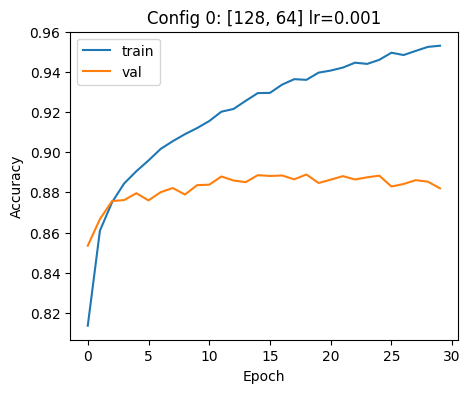

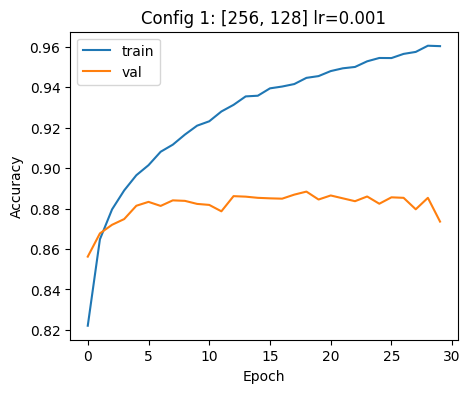

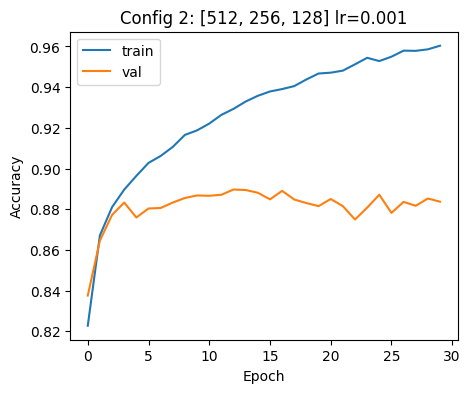

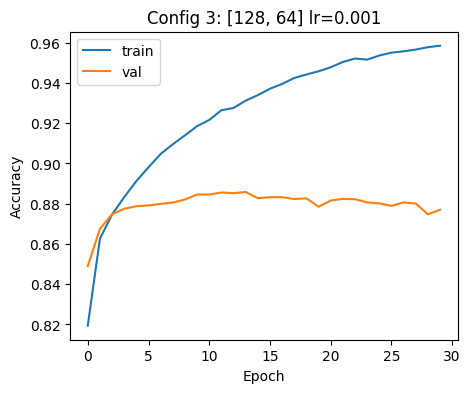

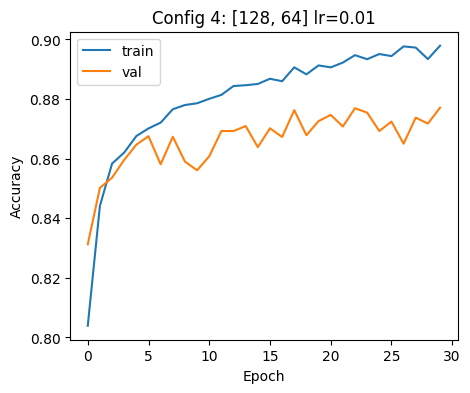

In [4]:
# results table
df_results = pd.DataFrame(results)
display(df_results)


# training vs validation curves
for i, h in enumerate(histories):
    plt.figure(figsize=(5, 4))
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Config {i}: {results[i]['hidden_layers']} lr={results[i]['learning_rate']}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


## Question 2: CNN vs Deep CNN with Hyperparameter Tuning

In [5]:
# CNN vs Deep CNN with Hyperparameter Tuning

# preparing data shapes
# converting flattened arrays from Question 1 back to images
xtr = x_train2.reshape(-1,28,28,1)
xval = x_val.reshape(-1,28,28,1)
xtest = x_test.reshape(-1,28,28,1)

# converting labels back from onehot to integer for confusion matrix
yval_int = np.argmax(y_val, axis=1)
ytest_int = np.argmax(y_test, axis=1)

# model builders
def build_basic_cnn(input_shape=(28,28,1), num_classes=10):
    # building basic cnn 1-2 conv blocks
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_deep_cnn(input_shape=(28,28,1), num_classes=10, dropout=0.4):
    # building deep cnn 3-4 conv blocks
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32,3,activation='relu',padding='same'))
    model.add(layers.Conv2D(32,3,activation='relu',padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64,3,activation='relu',padding='same'))
    model.add(layers.Conv2D(64,3,activation='relu',padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(128,3,activation='relu',padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


training basic_cnn
Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8356 - loss: 0.4626 - val_accuracy: 0.8798 - val_loss: 0.3291
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8940 - loss: 0.2962 - val_accuracy: 0.8943 - val_loss: 0.2877
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9109 - loss: 0.2492 - val_accuracy: 0.9031 - val_loss: 0.2647
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9209 - loss: 0.2172 - val_accuracy: 0.9109 - val_loss: 0.2484
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9310 - loss: 0.1904 - val_accuracy: 0.9133 - val_loss: 0.2436
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9402 - loss: 0.1663 - val_accuracy: 0.9147 - val_loss: 0.2532
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9487 - loss: 0.1445 - val_accuracy: 0.9170 - val_loss: 0.2590
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.956

saved: basic_cnn.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
classification report for basic_cnn
              precision    recall  f1-score   support

           0     0.8206    0.8460    0.8331      1000
           1     0.9969    0.9780    0.9874      1000
           2     0.8841    0.7780    0.8277      1000
           3     0.8812    0.9350    0.9073      1000
           4     0.8791    0.8220    0.8496      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.6946    0.7800    0.7348      1000
           7     0.9565    0.9680    0.9622      1000
           8     0.9888    0.9700    0.9793      1000
           9     0.9698    0.9640    0.9669      1000

    accuracy                         0.9022     10000
   macro avg     0.9051    0.9022    0.9028     10000
weighted avg     0.9051    0.9022    0.9028     10000



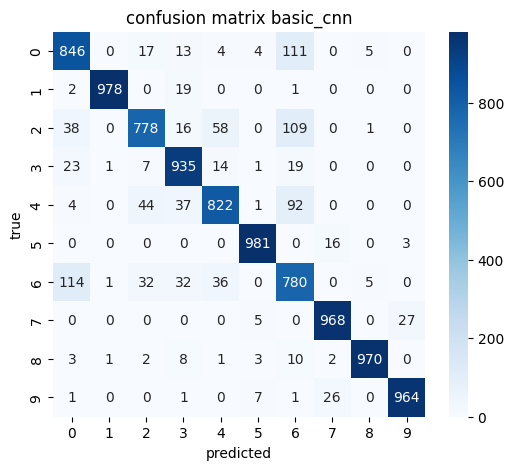

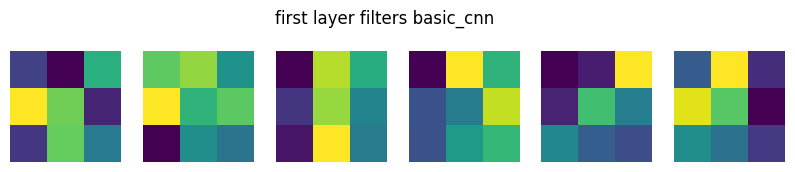

training deep_cnn
Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.8099 - loss: 0.5203 - val_accuracy: 0.8741 - val_loss: 0.3495
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8879 - loss: 0.3078 - val_accuracy: 0.8967 - val_loss: 0.2803
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.9061 - loss: 0.2569 - val_accuracy: 0.9053 - val_loss: 0.2542
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.9187 - loss: 0.2239 - val_accuracy: 0.9137 - val_loss: 0.2324
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9256 - loss: 0.1991 - val_accuracy: 0.9163 - val_loss: 0.2276
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9333 - loss: 0.1760 - val_accuracy: 0.9183 - val_loss: 0.2340
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9407 - loss: 0.1593 - val_accuracy: 0.9197 - val_loss: 0.2344
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9479

saved: deep_cnn.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
classification report for deep_cnn
              precision    recall  f1-score   support

           0     0.8740    0.8670    0.8705      1000
           1     0.9939    0.9830    0.9884      1000
           2     0.9220    0.8160    0.8658      1000
           3     0.9098    0.9180    0.9139      1000
           4     0.8716    0.8760    0.8738      1000
           5     0.9783    0.9920    0.9851      1000
           6     0.7385    0.8190    0.7767      1000
           7     0.9613    0.9700    0.9657      1000
           8     0.9801    0.9870    0.9836      1000
           9     0.9796    0.9610    0.9702      1000

    accuracy                         0.9189     10000
   macro avg     0.9209    0.9189    0.9194     10000
weighted avg     0.9209    0.9189    0.9194     10000



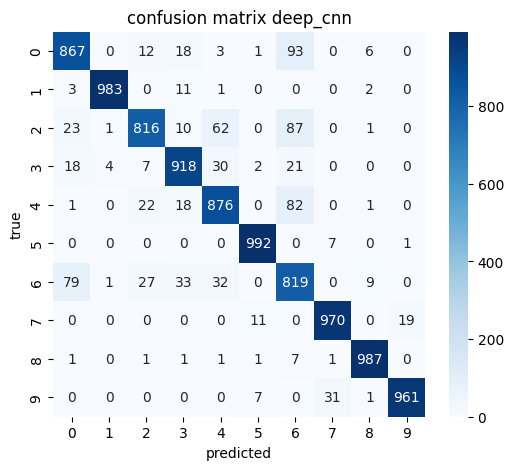

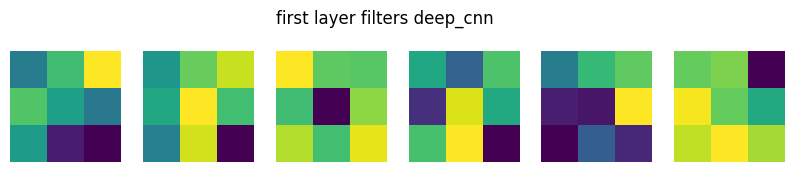

In [6]:
# experimental configs one at a time
configs = [
    {"name":"basic_cnn","builder":build_basic_cnn, "epochs":30, "bs":64},
    {"name":"deep_cnn","builder":build_deep_cnn, "epochs":30, "bs":64}
]

results = []
histories = {}

for cfg in configs:
    print("training", cfg["name"])
    model = cfg["builder"]()
    start = time.time()
    hist = model.fit(xtr, y_train2, validation_data=(xval, y_val), epochs=cfg["epochs"], batch_size=cfg["bs"], verbose=1)
    end = time.time()
    loss_test, acc_test = model.evaluate(xtest, y_test, verbose=0)

    #saving the model (.h5)
    model.save(f"{cfg['name']}.h5")
    print(f"saved: {cfg['name']}.h5")

    
    # saving results
    results.append({
        "model": cfg["name"],
        "train_acc": hist.history["accuracy"][-1],
        "val_acc": hist.history["val_accuracy"][-1],
        "test_acc": acc_test,
        "params": model.count_params(),
        "train_time_sec": round(end-start,2)
    })
    histories[cfg["name"]] = hist.history
    
    # computing confusion matrix and classification report
    ypred = model.predict(xtest)
    ypred_int = np.argmax(ypred, axis=1)
    cm = confusion_matrix(ytest_int, ypred_int)
    print("classification report for", cfg["name"])
    print(classification_report(ytest_int, ypred_int, digits=4))
    
    # plotting confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'confusion matrix {cfg["name"]}')
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()
    
    # Using exception handling we're visualizing a few filters from first conv layer if they available
    try:
        first_conv = [l for l in model.layers if isinstance(l, layers.Conv2D)][0]
        filters, biases = first_conv.get_weights()
        # normalizing filter values to 0-1 for display
        f_min, f_max = filters.min(), filters.max()
        filt = (filters - f_min) / (f_max - f_min)
        n_filters = min(6, filt.shape[3])
        plt.figure(figsize=(10,2))
        for i in range(n_filters):
            f = filt[:,:,:,i]
            # collapsing to single channel by averaging
            f_mean = np.mean(f, axis=2)
            plt.subplot(1,n_filters,i+1)
            plt.imshow(f_mean, cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'first layer filters {cfg["name"]}')
        plt.show()
    except Exception as e:
        print("filter visualization failed", e)


In [7]:
# summarizing results table
df_q2 = pd.DataFrame(results)
display(df_q2)
df_q2.to_csv("Q2_results.csv", index=False)

,model,train_acc,val_acc,test_acc,params,train_time_sec
0,basic_cnn,0.994208,0.911000,0.9022,421642,414.80
1,deep_cnn,0.985500,0.921167,0.9189,436586,1508.35


## Question 3: Data Augmentation with and without CNN

In [8]:
# Data Augmentation with and without CNN

# preparing images
xtr = x_train2.reshape(-1,28,28,1)
xval = x_val.reshape(-1,28,28,1)
xtest = x_test.reshape(-1,28,28,1)
ytest_int = np.argmax(y_test, axis=1)

# defining a cnn to use in both experiments
from tensorflow.keras import layers, models
def simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# setting up augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(xtr)

# training without augmentation
model_no_aug = simple_cnn()
start = time.time()
hist_no_aug = model_no_aug.fit(xtr, y_train2, validation_data=(xval, y_val), epochs=30, batch_size=64, verbose=1)
t_no_aug = time.time() - start
loss_test_no_aug, acc_test_no_aug = model_no_aug.evaluate(xtest, y_test, verbose=0)
ypred_no_aug = np.argmax(model_no_aug.predict(xtest), axis=1)
print("no aug test acc", acc_test_no_aug)
print(classification_report(ytest_int, ypred_no_aug, digits=4))
model_aug.save("cnn_with_augmentation.h5")

# training with augmentation
model_aug = simple_cnn()
start = time.time()
hist_aug = model_aug.fit(datagen.flow(xtr, y_train2, batch_size=64), validation_data=(xval, y_val), epochs=30, verbose=1, steps_per_epoch=len(xtr)//64)
t_aug = time.time() - start
loss_test_aug, acc_test_aug = model_aug.evaluate(xtest, y_test, verbose=0)
ypred_aug = np.argmax(model_aug.predict(xtest), axis=1)
print("aug test acc", acc_test_aug)
print(classification_report(ytest_int, ypred_aug, digits=4))
model_no_aug.save("cnn_no_augmentation.h5")

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8294 - loss: 0.4720 - val_accuracy: 0.8825 - val_loss: 0.3231
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8921 - loss: 0.3012 - val_accuracy: 0.8999 - val_loss: 0.2800
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9083 - loss: 0.2538 - val_accuracy: 0.9041 - val_loss: 0.2664
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9186 - loss: 0.2222 - val_accuracy: 0.9097 - val_loss: 0.2515
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9283 - loss: 0.1959 - val_accuracy: 0.9135 - val_loss: 0.2469
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9376 - loss: 0.1728 - val_accuracy: 0.9161 - val_loss: 0.2444
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9459 - loss: 0.1516 - val_accuracy: 0.9177 - val_loss: 0.2471
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9537 - loss: 0.1313 - 

In [9]:
# results table
res = [
    {"setting":"no_augmentation", "test_acc":acc_test_no_aug, "train_time_sec":round(t_no_aug,2)},
    {"setting":"with_augmentation", "test_acc":acc_test_aug, "train_time_sec":round(t_aug,2)}
]
df_q3 = pd.DataFrame(res)
display(df_q3)
df_q3.to_csv("Q3_results.csv", index=False)


,setting,test_acc,train_time_sec
0,no_augmentation,0.9076,511.21
1,with_augmentation,0.9127,4160.43


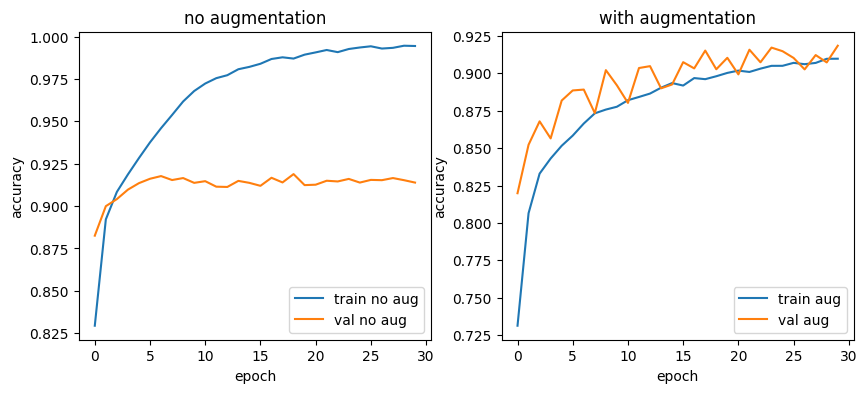

In [10]:
# plotting training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_no_aug.history['accuracy'], label='train no aug')
plt.plot(hist_no_aug.history['val_accuracy'], label='val no aug')
plt.title('no augmentation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_aug.history['accuracy'], label='train aug')
plt.plot(hist_aug.history['val_accuracy'], label='val aug')
plt.title('with augmentation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


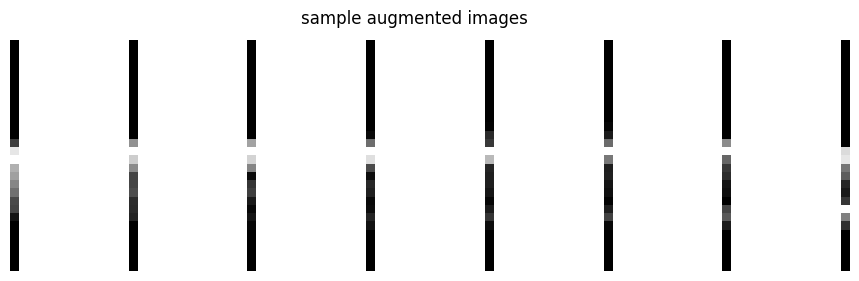

In [11]:
# sample augmented images
sample_iter = datagen.flow(xtr[:8], batch_size=8)
# getting first batch
sample_batch = next(sample_iter)  

plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(1,8,i+1)
    img = sample_batch[0][i]

    # ensure image is 2D for imshow
    if img.ndim == 3 and img.shape[-1] == 1:  #(28,28,1)
        img = img.squeeze(-1)
    elif img.ndim == 1:  #flattened, reshape to 28x28
        img = img.reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('sample augmented images')
plt.show()

## Question 4: Batch Normalization with and without CNN

In [12]:
# Batch Normalization with and without CNN

# preparing data
xtr = x_train2.reshape(-1,28,28,1)
xval = x_val.reshape(-1,28,28,1)
xtest = x_test.reshape(-1,28,28,1)
ytest_int = np.argmax(y_test, axis=1)

from tensorflow.keras import layers, models

def build_cnn(with_bn=False):
    # building cnn with optional batch normalization
    inp = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32,3,padding='same')(inp)
    if with_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64,3,padding='same')(x)
    if with_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    if with_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    out = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# training without bn
model_no_bn = build_cnn(with_bn=False)
start = time.time()
hist_no_bn = model_no_bn.fit(xtr, y_train2, validation_data=(xval, y_val), epochs=30, batch_size=64, verbose=1)
t_no_bn = time.time() - start
loss_no_bn, acc_no_bn = model_no_bn.evaluate(xtest, y_test, verbose=0)
ypred_no_bn = np.argmax(model_no_bn.predict(xtest), axis=1)
print("no bn test acc", acc_no_bn)
print(classification_report(ytest_int, ypred_no_bn, digits=4))

# training with bn
model_bn = build_cnn(with_bn=True)
start = time.time()
hist_bn = model_bn.fit(xtr, y_train2, validation_data=(xval, y_val), epochs=30, batch_size=64, verbose=1)
t_bn = time.time() - start
loss_bn, acc_bn = model_bn.evaluate(xtest, y_test, verbose=0)
ypred_bn = np.argmax(model_bn.predict(xtest), axis=1)
print("with bn test acc", acc_bn)
print(classification_report(ytest_int, ypred_bn, digits=4))

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8387 - loss: 0.4470 - val_accuracy: 0.8811 - val_loss: 0.3217
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8955 - loss: 0.2904 - val_accuracy: 0.8989 - val_loss: 0.2812
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9099 - loss: 0.2476 - val_accuracy: 0.9015 - val_loss: 0.2720
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9195 - loss: 0.2177 - val_accuracy: 0.9098 - val_loss: 0.2616
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9306 - loss: 0.1918 - val_accuracy: 0.9113 - val_loss: 0.2544
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9396 - loss: 0.1676 - val_accuracy: 0.9089 - val_loss: 0.2677
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9487 - loss: 0.1458 - val_accuracy: 0.9063 - val_loss: 0.2926
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9556 - loss: 0.1257 - 

,setting,test_acc,train_time_sec
0,no_batchnorm,0.9078,551.01
1,with_batchnorm,0.9060,1240.89


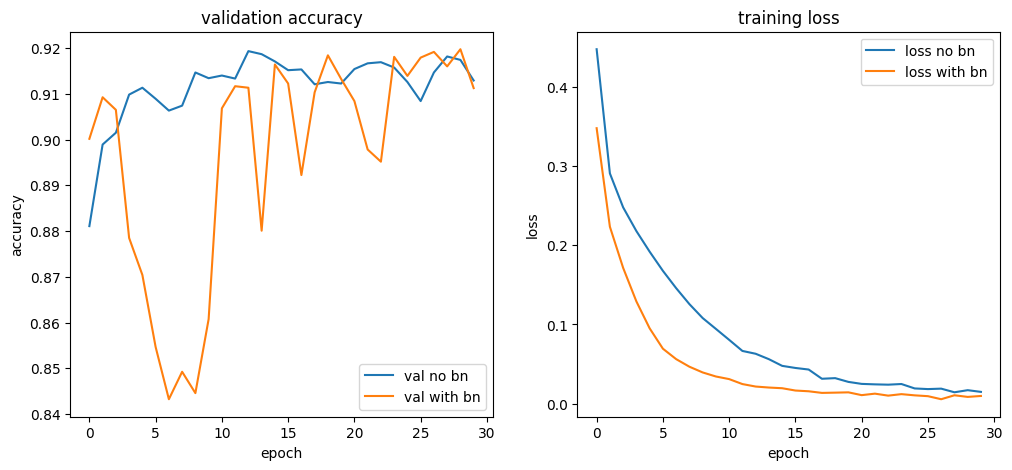

In [13]:
# results table and plots
res = [
    {"setting":"no_batchnorm","test_acc":acc_no_bn, "train_time_sec":round(t_no_bn,2)},
    {"setting":"with_batchnorm","test_acc":acc_bn, "train_time_sec":round(t_bn,2)}
]
df_q4 = pd.DataFrame(res)
display(df_q4)
df_q4.to_csv("Q4_results.csv", index=False)

# plotting accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_no_bn.history['val_accuracy'], label='val no bn')
plt.plot(hist_bn.history['val_accuracy'], label='val with bn')
plt.title('validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_no_bn.history['loss'], label='loss no bn')
plt.plot(hist_bn.history['loss'], label='loss with bn')
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


## Question 5: Transfer Learning With MOBILENETV2

In [14]:
# Resizing Images to 96×96 for Transfer Learning
# resizing 28×28 grayscale images to 96×96 RGB to use pre-trained models and avoid memory issues

IMG_SIZE = (96, 96)
BATCH = 32
AUTO = tf.data.AUTOTUNE

def prep(x, y):
    x = tf.reshape(x, [28,28,1])
    x = tf.image.grayscale_to_rgb(x)
    x = tf.image.resize(x, IMG_SIZE)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((x_train2, y_train2)).shuffle(5000).map(prep).batch(BATCH).prefetch(AUTO)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(prep).batch(BATCH).prefetch(AUTO)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(prep).batch(BATCH).prefetch(AUTO)

base = tf.keras.applications.MobileNetV2(
    input_shape=(96,96,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = layers.Input(shape=(96,96,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_t = models.Model(inputs, outputs)
model_t.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss="categorical_crossentropy",
                metrics=["accuracy"])


In [15]:
print("\nTRAIN MOBILENET HEAD")
hist1 = model_t.fit(train_ds, validation_data=val_ds, epochs=6)

print("\nFINE TUNE")
base.trainable = True
for layer in base.layers[:-25]:
    layer.trainable = False

model_t.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

hist2 = model_t.fit(train_ds, validation_data=val_ds, epochs=6)
model_t.save("mobilenetv2_trained.h5")


TRAIN MOBILENET HEAD
Epoch 1/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 264s 170ms/step - accuracy: 0.1444 - loss: 2.3005 - val_accuracy: 0.3873 - val_loss: 2.2678
Epoch 2/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 250s 167ms/step - accuracy: 0.2108 - loss: 2.2418 - val_accuracy: 0.2641 - val_loss: 2.1993
Epoch 3/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 257s 172ms/step - accuracy: 0.2563 - loss: 2.1485 - val_accuracy: 0.3836 - val_loss: 2.0706
Epoch 4/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 250s 167ms/step - accuracy: 0.2825 - loss: 2.0254 - val_accuracy: 0.3876 - val_loss: 1.9296
Epoch 5/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 257s 171ms/step - accuracy: 0.3045 - loss: 1.9095 - val_accuracy: 0.4058 - val_loss: 1.8068
Epoch 6/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 256s 171ms/step - accuracy: 0.3217 - loss: 1.8192 - val_accuracy: 0.4470 - val_loss: 1.7036

FINE TUNE
Epoch 1/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 363s 229ms/step - accuracy: 0.6973 - loss: 0.8738 - val_accuracy: 0.1004 - val_loss: 6.7388
Epoch 2/6
1500/1500 ━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.8271 - loss: 0.4712
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step

Final accuracy: 0.8270999789237976
              precision    recall  f1-score   support

           0     0.6431    0.9280    0.7597      1000
           1     0.9877    0.9660    0.9767      1000
           2     0.7263    0.8200    0.7703      1000
           3     0.9031    0.7360    0.8110      1000
           4     0.7527    0.7670    0.7598      1000
           5     0.8072    0.9840    0.8869      1000
           6     0.6848    0.4410    0.5365      1000
           7     0.9515    0.7460    0.8363      1000
           8     0.9761    0.9380    0.9567      1000
           9     0.9375    0.9450    0.9412      1000

    accuracy                         0.8271     10000
   macro avg     0.8370    0.8271    0.8235     10000
weighted avg     0.8370    0.8271    0.8235     10000



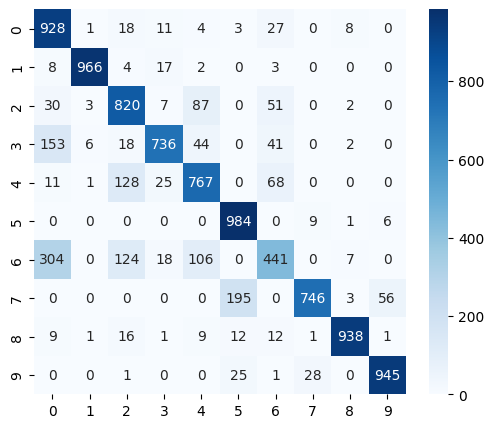

In [16]:
# evaluation
loss_ft, acc_ft = model_t.evaluate(test_ds)
ypred = np.argmax(model_t.predict(test_ds), axis=1)
ytrue = np.argmax(y_test, axis=1)

print("\nFinal accuracy:", acc_ft)
print(classification_report(ytrue, ypred, digits=4))

cm = confusion_matrix(ytrue, ypred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()
